In [10]:
!pip install xlrd

   ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/96.5 kB ? eta -:--:--
   ---------------------------------------- 96.5/96.5 kB 1.4 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [19]:
import pandas as pd

# Read the Excel file
file_path = "hv15401j.xls"  
data = pd.read_excel(file_path, header=6, sheet_name='月・実数')
data = data.drop(index=0)
data = data.drop(df.columns[-1], axis=1)
data.columns = ["time_code", "date", "total_sales", "admission_sales", "restaurant_sales", "total_visitors",
              "individual_visitors", "group_visitors", "total_employees", "regular_workers", "part_time_workers"]

# Display the first few rows
print(data.head())

    time_code      date total_sales admission_sales restaurant_sales  \
1  2000000101  2000年 1月       15650            8360             7290   
2  2000000202  2000年 2月       14509            7377             7132   
3  2000000303  2000年 3月       28629           14695            13934   
4  2000000404  2000年 4月       23159           12416            10743   
5  2000000505  2000年 5月       29505           16226            13279   

  total_visitors individual_visitors group_visitors total_employees  \
1        2996812             2755960         240852           22319   
2        2654913             2236941         417972           22565   
3        5272017             4458895         813122           24063   
4        4415311             3638835         776476           24486   
5        6036756             4727314        1309442           24762   

  regular_workers part_time_workers  
1            6164             16155  
2            6095             16470  
3            6635         

In [28]:
import pandas as pd

# Assume your DataFrame is named 'data'
# Define a regex pattern to match dates like "2000年1月" or "2000年 1月"
date_pattern = r'^\d{4}年\s?\d{1,2}月$'

# Create a mask to select only rows that match the date pattern
mask = data["date"].str.match(date_pattern)

# Filter the DataFrame to keep only valid date rows
data_valid = data[mask].copy()

# Remove any extra space between "年" and the month
data_valid["date"] = data_valid["date"].str.replace("年 ", "年", regex=False)

# Convert the date column to datetime using the correct format
data_valid["date"] = pd.to_datetime(data_valid["date"], format="%Y年%m月")

print(data_valid.head())

    time_code       date total_sales admission_sales restaurant_sales  \
1  2000000101 2000-01-01       15650            8360             7290   
2  2000000202 2000-02-01       14509            7377             7132   
3  2000000303 2000-03-01       28629           14695            13934   
4  2000000404 2000-04-01       23159           12416            10743   
5  2000000505 2000-05-01       29505           16226            13279   

  total_visitors individual_visitors group_visitors total_employees  \
1        2996812             2755960         240852           22319   
2        2654913             2236941         417972           22565   
3        5272017             4458895         813122           24063   
4        4415311             3638835         776476           24486   
5        6036756             4727314        1309442           24762   

  regular_workers part_time_workers  
1            6164             16155  
2            6095             16470  
3            6635   

In [37]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayushtankha/hackathon")
attendance = pd.read_csv(f"{path}/attendance.csv")  
attendance.head()
data_valid.head()

,time_code,date,total_sales,admission_sales,restaurant_sales,total_visitors,individual_visitors,group_visitors,total_employees,regular_workers,part_time_workers
1,2000000101,2000-01-01,15650,8360,7290,2996812,2755960,240852,22319,6164,16155
2,2000000202,2000-02-01,14509,7377,7132,2654913,2236941,417972,22565,6095,16470
3,2000000303,2000-03-01,28629,14695,13934,5272017,4458895,813122,24063,6635,17428
4,2000000404,2000-04-01,23159,12416,10743,4415311,3638835,776476,24486,6823,17663
5,2000000505,2000-05-01,29505,16226,13279,6036756,4727314,1309442,24762,6746,18016


In [39]:
attendance["USAGE_DATE"] = pd.to_datetime(attendance["USAGE_DATE"])
# Create a year-month column in attendance and data_valid (the cleaned sales/visitor dataset)
attendance["year_month"] = attendance["USAGE_DATE"].dt.to_period("M")
data_valid["year_month"] = pd.to_datetime(data_valid["date"], errors="coerce").dt.to_period("M") 

# Merge attendance data with sales/visitor dataset on the date
merged_df = pd.merge(attendance, data_valid, left_on="year_month", right_on="year_month", how="left")

In [56]:
merged_df.head()
merged_df["staff_count"] = np.ceil(merged_df["attendance"] / (merged_df["total_visitors"] / merged_df["total_employees"]))
selected = merged_df[["USAGE_DATE","FACILITY_NAME","attendance","staff_count"]]
selected.head()


,USAGE_DATE,FACILITY_NAME,attendance,staff_count
0,2018-06-01,PortAventura World,46804,376
1,2018-06-01,Tivoli Gardens,20420,164
2,2018-06-02,PortAventura World,57940,465
3,2018-06-02,Tivoli Gardens,29110,234
4,2018-06-03,PortAventura World,44365,356


In [57]:
# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = selected
data["year"] = data["USAGE_DATE"].dt.year
data["month"] = data["USAGE_DATE"].dt.month
data["day"] = data["USAGE_DATE"].dt.day

# One-hot encode FACILITY_NAME
data_encoded = pd.get_dummies(data, columns=["FACILITY_NAME"], drop_first=True)

# ---------------------
# 3. Define Features and Target
# ---------------------
# We will use attendance and date features as predictors
features = ["attendance", "year", "month", "day"] + [col for col in data_encoded.columns if col.startswith("FACILITY_NAME_")]
target = "staff_count"

X = data_encoded[features]
y = data_encoded[target]

# ---------------------
# 4. Split Data
# ---------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------
# 5. Train a Model
# ---------------------
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ---------------------
# 6. Evaluate Model
# ---------------------
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

C:\Users\ReginaNoel\AppData\Local\Temp\ipykernel_10636\1725818613.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["year"] = data["USAGE_DATE"].dt.year
C:\Users\ReginaNoel\AppData\Local\Temp\ipykernel_10636\1725818613.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["month"] = data["USAGE_DATE"].dt.month
C:\Users\ReginaNoel\AppData\Local\Temp\ipykernel_10636\1725818613.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Mean Absolute Error: 21.96
Mean Squared Error: 9357.96
R^2 Score: 0.88


In [58]:
from sklearn.model_selection import cross_val_score, KFold

# Calculate RMSE from MSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Perform k-fold cross-validation (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf)
cv_mae = -np.mean(cv_scores)
print(f"5-Fold Cross-Validated MAE: {cv_mae:.2f}")

Root Mean Squared Error: 96.74
Mean Absolute Percentage Error: 8.38%
5-Fold Cross-Validated MAE: 22.31


##Ignore all of these first

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv("rnsas.csv") 

In [ ]:
print(df)

In [33]:
import math

# Calculate Staff Needed
df["Staff Needed"] = ((df["Target Ratio"] * df["Population"]) / 100000) - df["Employed RNs"]
df["Staff Needed"] = df["Staff Needed"].apply(lambda x: max(0, math.ceil(x)))  # Round up and ensure non-negative

# Calculate Total Staff Need
df["Total Staff Need"] = (df["Target Ratio"] * df["Population"]) / 100000
df["Total Staff Need"] = df["Total Staff Need"].apply(lambda x: max(0, math.ceil(x)))  # Round up and ensure non-negative

#Calculate Gap
df['Gap Ratio'] = (df["Target Ratio"] - df["Ratio"]) 
df["Gap Ratio"] = df["Gap Ratio"].apply(lambda x: max(0, math.ceil(x))) 

In [ ]:
print(df)

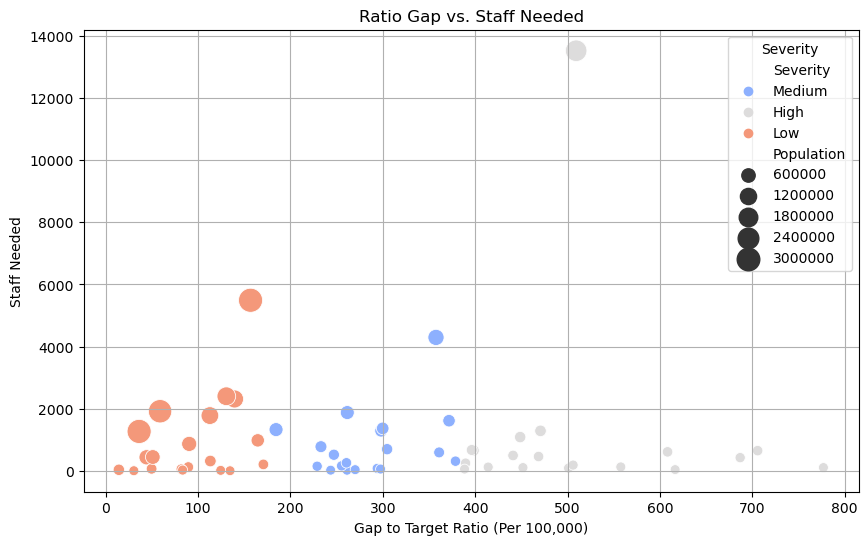

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Target Ratio to numeric (if needed)
df["Target Ratio"] = pd.to_numeric(df["Target Ratio"], errors="coerce")

# Calculate the Ratio Gap (difference between Target and Current)
df["Ratio Gap"] = df["Target Ratio"] - df["Ratio"]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Ratio Gap", y="Staff Needed", hue="Severity", size="Population", sizes=(50, 300), palette="coolwarm")

plt.title("Ratio Gap vs. Staff Needed")
plt.xlabel("Gap to Target Ratio (Per 100,000)")
plt.ylabel("Staff Needed")
plt.legend(title="Severity")
plt.grid()
plt.show()

c:\Users\ReginaNoel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ReginaNoel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ReginaNoel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ReginaNoel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

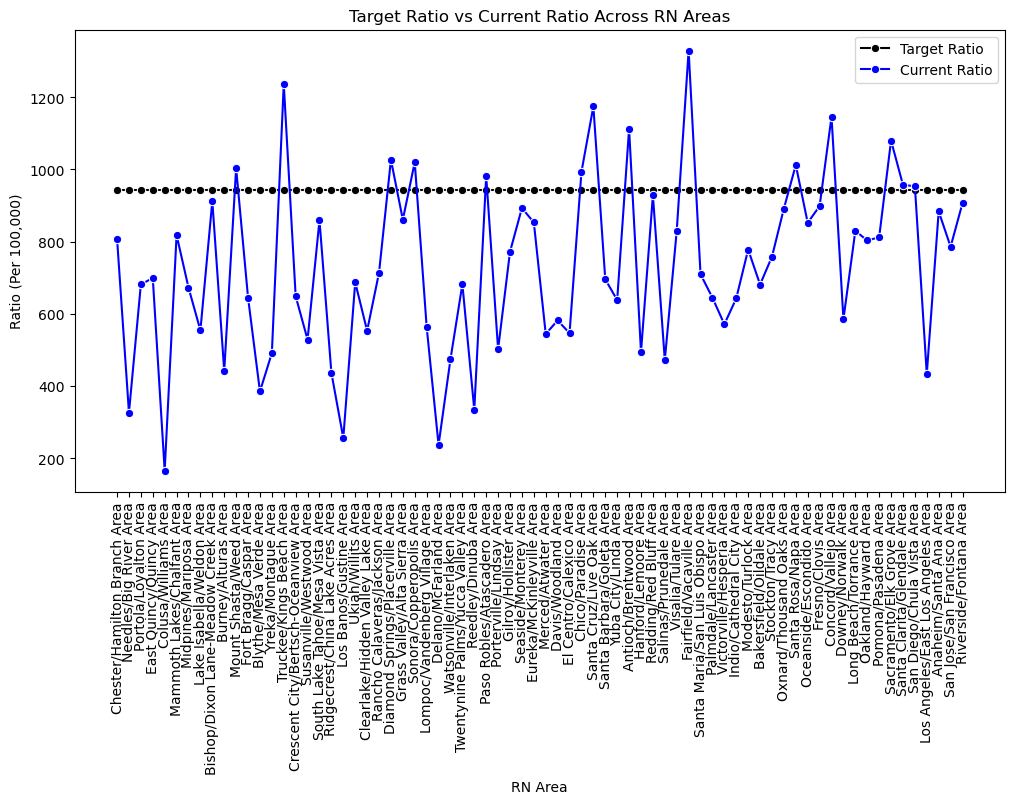

In [ ]:
df = df.sort_values(by="Population")  # Sort for better visualization

plt.figure(figsize=(12, 6))
sns.lineplot(x=df["RN Area Name"], y=df["Target Ratio"], label="Target Ratio", marker="o", color="black")
sns.lineplot(x=df["RN Area Name"], y=df["Ratio"], label="Current Ratio", marker="o", color="blue")

plt.xticks(rotation=90)
plt.title("Target Ratio vs Current Ratio Across RN Areas")
plt.xlabel("RN Area")
plt.ylabel("Ratio (Per 100,000)")
plt.legend()
plt.show()

In [ ]:
#Severity is NOT about staff count but about the gap in ratios.
#Big areas with large staff needs can have low Severity because their Ratio is close to Target.
#Small areas with even a 50-staff shortage can have HIGH severity because their Ratio is way below Target.
#The gap to target ratio varies with a few having ratio exceeding the target ratio

In [2]:
import kagglehub

#Ice coffee shop
# Download latest version
path = kagglehub.dataset_download("viramatv/coffee-shop-data")
df2 = pd.read_csv(f"{path}/orders.csv")  
df3 = pd.read_csv(f"{path}/shift.csv") 
df4 = pd.read_csv(f"{path}/rota.csv") 
df5 = pd.read_csv(f"{path}/staff.csv") 

In [3]:
import pandas as pd

# Load datasets
df_orders = pd.read_csv(f"{path}/orders.csv", parse_dates=["created_at"])
df_shifts = pd.read_csv(f"{path}/shift.csv")
df_rota = pd.read_csv(f"{path}/rota.csv", parse_dates=["date"])
df_staff = pd.read_csv(f"{path}/staff.csv")

In [4]:
print(df_orders)

     row_id order_id          created_at item_id  quantity cust_name in_or_out
0         1   ORD001 2024-02-12 07:04:19   It008         1      Alex       out
1         2   ORD002 2024-02-12 07:09:38   It014         1    Jordan        in
2         3   ORD003 2024-02-12 07:14:29   It008         1    Taylor       out
3         4   ORD004 2024-02-12 07:18:39   It019         1     Casey       out
4         5   ORD005 2024-02-12 07:23:44   It024         1     Jamie       out
..      ...      ...                 ...     ...       ...       ...       ...
516     517   ORD433 2024-02-17 16:11:00   It023         1      Gina        in
517     518   ORD434 2024-02-17 16:27:00   It006         1      Hugh       out
518     519   ORD435 2024-02-17 16:43:00   It018         1      Iris        in
519     520   ORD436 2024-02-17 16:59:00   It002         1      Jack       out
520     521   ORD437 2024-02-17 17:00:00   It026         1     Kiera        in

[521 rows x 7 columns]


In [5]:
df_orders["day_of_week"] = df_orders["created_at"].dt.day_name()
df_orders["time"] = df_orders["created_at"].dt.time
print(df_orders)

     row_id order_id          created_at item_id  quantity cust_name  \
0         1   ORD001 2024-02-12 07:04:19   It008         1      Alex   
1         2   ORD002 2024-02-12 07:09:38   It014         1    Jordan   
2         3   ORD003 2024-02-12 07:14:29   It008         1    Taylor   
3         4   ORD004 2024-02-12 07:18:39   It019         1     Casey   
4         5   ORD005 2024-02-12 07:23:44   It024         1     Jamie   
..      ...      ...                 ...     ...       ...       ...   
516     517   ORD433 2024-02-17 16:11:00   It023         1      Gina   
517     518   ORD434 2024-02-17 16:27:00   It006         1      Hugh   
518     519   ORD435 2024-02-17 16:43:00   It018         1      Iris   
519     520   ORD436 2024-02-17 16:59:00   It002         1      Jack   
520     521   ORD437 2024-02-17 17:00:00   It026         1     Kiera   

    in_or_out day_of_week      time  
0         out      Monday  07:04:19  
1          in      Monday  07:09:38  
2         out      Mo

In [ ]:
# Merge orders with shifts based on day and time
df_shifts.loc[df_shifts["end_time"] == "13:00:00", "end_time"] = "12:59:59"
merged_orders = df_orders.merge(df_shifts, on="day_of_week", how="left")
merged_orders = merged_orders[(merged_orders["time"] >= pd.to_datetime(merged_orders["start_time"]).dt.time) & 
                              (merged_orders["time"] <= pd.to_datetime(merged_orders["end_time"]).dt.time)]

print(merged_orders)


In [48]:
# Convert created_at to date to match rota
merged_orders["date"] = merged_orders["created_at"].dt.date.astype(str)
df_rota["date"] = df_rota["date"].astype(str)

# Merge with rota to get staff_id
merged_orders = merged_orders.merge(df_rota, on=["date", "shift_id"], how="left")

In [50]:
# Merge with staff details
final_df = merged_orders.merge(df_staff, on="staff_id", how="left")

# Add staff managing count
final_df["staff_managing_count"] = final_df.groupby(["order_id", "item_id"])['staff_id'].transform('nunique')

In [ ]:
print(final_df)

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
dff = final_df.drop_duplicates(subset=["order_id", "item_id","row_id_x"])
dff = dff[["row_id_x","order_id", "created_at", "item_id", "quantity", "cust_name", "in_or_out","staff_managing_count"]]
print(dff)

In [53]:
print(dff.shape)

(520, 8)


In [54]:
# Convert created_at to datetime if not already
dff["created_at"] = pd.to_datetime(dff["created_at"])

# Extract date and hour
dff["date"] = dff["created_at"].dt.date
dff["hour"] = dff["created_at"].dt.hour

In [ ]:
print(dff)

In [56]:
# Group by date and hour, counting unique order_ids
order_counts = dff.groupby(["date", "hour","staff_managing_count"])[["row_id_x"]].nunique().reset_index()
# Rename column
order_counts.rename(columns={"row_id_x": "order_count"}, inplace=True)

In [ ]:
total_orders = order_counts["order_count"].sum()
print(total_orders)
order_counts.head()
print(order_counts)


c:\Users\ReginaNoel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ReginaNoel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ReginaNoel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ReginaNoel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

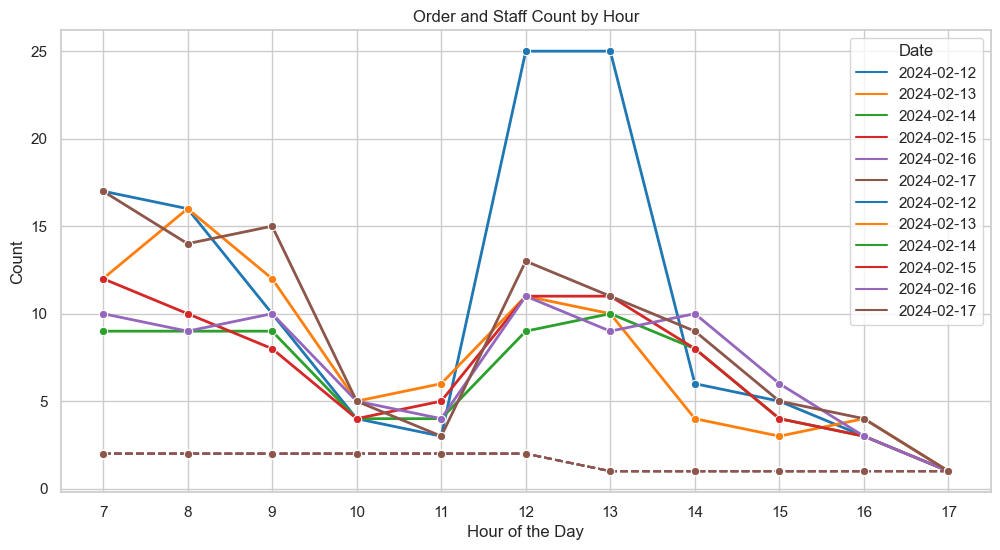

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")
# Create the plot
plt.figure(figsize=(12, 6))
# Plot order count
sns.lineplot(data=order_counts, x="hour", y="order_count", hue="date", marker="o", linewidth=2, palette="tab10",)
sns.lineplot(data=order_counts, x="hour", y="staff_managing_count", hue="date", marker="o", linestyle="dashed", palette="tab10")
# Labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.title("Order and Staff Count by Hour")
plt.legend(title="Date")
plt.xticks(range(7, 18))  # Assuming hours are from 7 to 17
plt.show()

In [ ]:
print(order_counts)

In [ ]:
#bind the 2 dataset 
# join on with uss datset visitor count -> make column for employee number prediction
# use it as y
the x use the season, weather, date, num of visitor